In [1]:
import sys
import os
from os import sep
from os.path import dirname, realpath
from pathlib import Path
from itertools import product, zip_longest, chain
from collections import Mapping
import logging

def get_cwd(fname, subdir, crunch_dir=realpath(Path.home()) +sep +'crunch' +sep):
    """
    Convenience function to make a directory string for the current file based on inputs.
    Jupyter Notebook in Anaconda invokes the Python interpreter in Anaconda's subdirectory
    which sis why changing sys.argv[0] is necessary. In the future a better way to do this
    should be preferred..
    """
    return crunch_dir +subdir +fname

def fix_path(cwd):
    """
    Convenience function to fix argv and python path so that jupyter notebook can run the same as
    any script in crunch.
    """
    sys.argv[0] = cwd
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

fix_path(get_cwd('viz_trmi.ipynb', 'mutate' +sep))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit, vectorize, float64, uint
from scipy.stats import zscore
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA, SparsePCA, FactorAnalysis
from sortedcontainers import SortedList, SortedSet 
from graphviz import Digraph

from ipywidgets import interact, interactive, fixed
from IPython.display import display, Image

pd.set_option("display.max_rows", 100)
pd.set_option('display.max_columns', 50)

from common_util import DT_HOURLY_FREQ, DT_CAL_DAILY_FREQ, DT_BIZ_DAILY_FREQ, window_iter, col_iter, all_equal, list_get_dict, get_custom_biz_freq, get_custom_biz_freq_df, query_df, search_df, chained_filter, benchmark
from common_util import MUTATE_DIR, dict2dag, load_json, is_type, df_rows_in_year, isnt, find_numbers, outer_join, left_join, count_nn_df, count_nz_df, count_nn_nz_df, pairwise, cust_count, suffix_map
from data.data_api import DataAPI
from mutate.common import RVIZ_DIR
from mutate.runt import get_rm_keychain, apply_rm
DataAPI.__init__()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Load Data

In [2]:
recs, dfs = DataAPI.axe_load(['root', 'root_split'], lazy=False)

/home/kev/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:698: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/home/kev/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:725: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/home/kev/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:742: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [3]:
list(dfs.keys())

[['dow_jones', 'root', 'root_split', 'join', 'pba'],
 ['dow_jones', 'root', 'root_split', 'join', 'trmi2'],
 ['dow_jones', 'root', 'root_split', 'join', 'trmi3'],
 ['dow_jones', 'root', 'root_split', 'join', 'vol'],
 ['nasdaq_100', 'root', 'root_split', 'join', 'pba'],
 ['nasdaq_100', 'root', 'root_split', 'join', 'trmi2'],
 ['nasdaq_100', 'root', 'root_split', 'join', 'trmi3'],
 ['nasdaq_100', 'root', 'root_split', 'join', 'vol'],
 ['russell_2000', 'root', 'root_split', 'join', 'pba'],
 ['russell_2000', 'root', 'root_split', 'join', 'trmi2'],
 ['russell_2000', 'root', 'root_split', 'join', 'trmi3'],
 ['russell_2000', 'root', 'root_split', 'join', 'vol'],
 ['sp_500', 'root', 'root_split', 'join', 'pba'],
 ['sp_500', 'root', 'root_split', 'join', 'trmi2'],
 ['sp_500', 'root', 'root_split', 'join', 'trmi3'],
 ['sp_500', 'root', 'root_split', 'join', 'vol']]

In [18]:
asset = 'sp_500'
trmi_vers = ['v2', 'v3']
trmi_vernums = list(map(lambda verstr: find_numbers(verstr)[-1], trmi_vers))
trmi = {vs: dfs[[asset, 'root', 'root_split', 'join', 'trmi{vn:d}'.format(vn=vn)]] for vs, vn in zip(trmi_vers, trmi_vernums)}

NameError: name 'dfs' is not defined

In [5]:
srcs = ('_N', '_S')
trmi_types = {vs: list(set(map(lambda name: name.split('_')[0], trmi[vs].columns))) for vs in trmi_vers}
trmi_sources = {vs: list(set(filter(lambda sfx: sfx is not None, map(lambda name: name[-2:] if name[-2:] in srcs else None, trmi[vs].columns)))) for vs in trmi_vers}

In [6]:
trmi_cols = {vs: {t: {s: list(filter(lambda name: name.startswith(t) and name.endswith(s), trmi[vs].columns)) for s in trmi_sources[vs]} for t in trmi_types[vs]} for vs in trmi_vers}

## TRMI Data Description Graphs

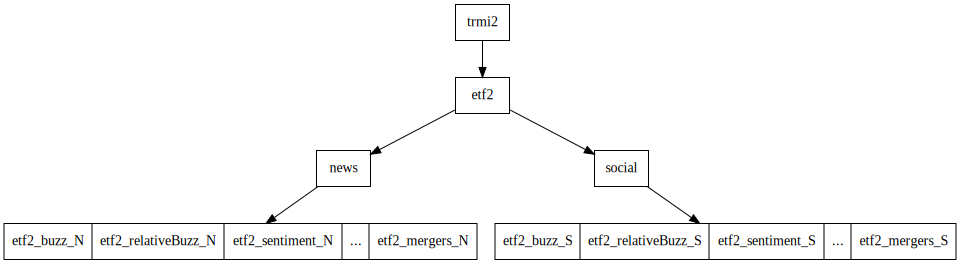

In [7]:
g2 = dict2dag({'trmi2': trmi_cols['v2']}, remap={'_N': 'news', '_S': 'social'}, list_max=5, \
             name='raw_trmi_v2', engine='dot', format='png', node_attr={'shape': 'record'}, \
             graph_attr={'overlap': 'false', 'label': '', 'fontsize': '20'})
display(g2)
#g2.render(RVIZ_DIR +'raw_trmi_v2.png')

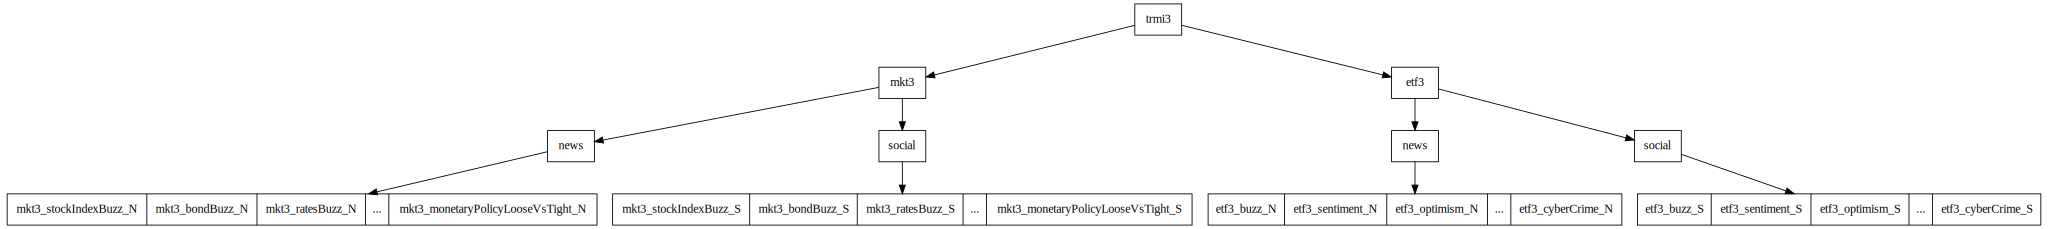

In [8]:
g3 = dict2dag({'trmi3': trmi_cols['v3']}, remap={'_N': 'news', '_S': 'social'}, list_max=5, \
             name='raw_trmi_v3', engine='dot', format='png', node_attr={'shape': 'record'}, \
             graph_attr={'overlap': 'false', 'label': '', 'fontsize': '20'})
display(g3)
#g3.render(RVIZ_DIR +'raw_trmi_v3.png')

## TRMI Column Name Analysis

### TRMI MKT NEWS BUZZ

In [16]:
dfs[['sp_500', 'root', 'root_split', 'join', 'trmi3']].loc[:, trmi_cols['v3']['mkt3']['_N']].dropna().abs().mean()

mkt3_stockIndexBuzz_N                7075.011069
mkt3_bondBuzz_N                      5547.803431
mkt3_ratesBuzz_N                     3168.671771
mkt3_stockIndexSentiment_N              0.149329
mkt3_stockIndexOptimism_N               0.019913
mkt3_stockIndexTrust_N                  0.004965
mkt3_stockIndexFear_N                   0.012006
mkt3_stockIndexStress_N                 0.041382
mkt3_stockIndexSurprise_N               0.004457
mkt3_stockIndexUncertainty_N            0.027497
mkt3_stockIndexMarketRisk_N             0.017103
mkt3_stockIndexPriceDirection_N         0.071627
mkt3_stockIndexPriceForecast_N          0.003822
mkt3_stockIndexVolatility_N             0.034360
mkt3_bondSentiment_N                    0.131993
mkt3_bondOptimism_N                     0.027594
mkt3_bondTrust_N                        0.003645
mkt3_bondFear_N                         0.011586
mkt3_bondStress_N                       0.070749
mkt3_bondSurprise_N                     0.003762
mkt3_bondUncertainty

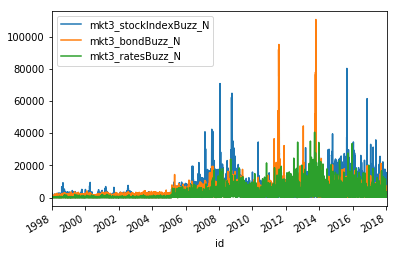

In [17]:
dfs[['sp_500', 'root', 'root_split', 'join', 'trmi3']].loc[:, trmi_cols['v3']['mkt3']['_N']][['mkt3_stockIndexBuzz_N', 'mkt3_bondBuzz_N', 'mkt3_ratesBuzz_N']].dropna().plot()

In [18]:
dfs[['sp_500', 'root', 'root_split', 'join', 'trmi3']].loc[:, trmi_cols['v3']['mkt3']['_N']][['mkt3_stockIndexBuzz_N', 'mkt3_bondBuzz_N', 'mkt3_ratesBuzz_N']].dropna()

,mkt3_stockIndexBuzz_N,mkt3_bondBuzz_N,mkt3_ratesBuzz_N
id,,,
1998-01-01 15:00:00+00:00,579.500000,307.5,32.5
1998-01-01 16:00:00+00:00,562.500000,307.5,32.5
1998-01-01 17:00:00+00:00,538.500000,298.5,31.5
1998-01-01 18:00:00+00:00,285.500000,90.0,16.5
1998-01-01 19:00:00+00:00,242.000000,88.5,16.5
1998-01-01 20:00:00+00:00,242.000000,72.0,15.5
1998-01-01 21:00:00+00:00,242.000000,72.0,15.5
1998-01-01 22:00:00+00:00,165.000000,56.0,15.5
1998-01-01 23:00:00+00:00,52.000000,48.0,14.5


### TRMI3 NonBuzz Missing Data

In [5]:
thresh = .90
hrm_recs, hrm_dfs = DataAPI.axe_load(['hrm', 'hrm'], lazy=False)
res_df = pd.DataFrame()

for trmi_src in ['news', 'social']:
    res_df = pd.DataFrame()
    trmi_rcs, trmi_dfs = DataAPI.axe_load(['root', 'root_trmi3_{}_nonbuzz'.format(trmi_src)], lazy=False)
    for key, trmi_df in trmi_dfs.items():
        asset, subset = key[0], key[-1]
        hrm_df = hrm_dfs[get_rm_keychain(key, hrm_dfs.keys())]
        src_df = df_rows_in_year(apply_rm(trmi_df, hrm_df), years=(2009, 2018))
        cnt = src_df.abs().groupby(pd.Grouper(freq='D')).max().count(numeric_only=True)
        all_cnt = cnt.max()
        misscols = cnt.loc[cnt < all_cnt*thresh]
        if (not misscols.empty):
            statdf = pd.concat([misscols, misscols/all_cnt], axis=1)
            statdf[2] = statdf.index
            statdf[3] = asset
            statdf[4] = '_'.join(subset.split('_')[-2:])
            statdf = statdf[[2, 3, 4, 0, 1]]
            statdf.columns = ['Series', 'Index', 'Subset', 'Num', 'Pct']
            res_df = pd.concat([res_df, statdf]).reset_index(drop=True)
    #res_df.to_csv(RVIZ_DIR +'missing-data_trmi3-{}.csv'.format(trmi_src))
    display(res_df)

,Series,Index,Subset,Num,Pct
0,etf3_laborDispute_N,dow_jones,news_fundamental,2264,0.688774
1,etf3_laborDispute_N,nasdaq_100,news_fundamental,1628,0.495284
2,etf3_laborDispute_N,russell_2000,news_fundamental,1319,0.401278
3,etf3_laborDispute_N,sp_500,news_fundamental,2910,0.885306


,Series,Index,Subset,Num,Pct
0,etf3_laborDispute_S,dow_jones,social_fundamental,1967,0.598418
1,mkt3_interestRatesForecast_S,dow_jones,social_bank,2942,0.895041
2,mkt3_bondPriceForecast_S,dow_jones,social_bond,2721,0.827807
3,etf3_laborDispute_S,nasdaq_100,social_fundamental,1132,0.344387
4,mkt3_interestRatesForecast_S,nasdaq_100,social_bank,2942,0.895041
5,mkt3_bondPriceForecast_S,nasdaq_100,social_bond,2721,0.827807
6,etf3_laborDispute_S,russell_2000,social_fundamental,977,0.297232
7,mkt3_interestRatesForecast_S,russell_2000,social_bank,2942,0.895041
8,mkt3_bondPriceForecast_S,russell_2000,social_bond,2721,0.827807
9,etf3_laborDispute_S,sp_500,social_fundamental,2618,0.796471
